In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

In [3]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
           's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

feature_columns = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
                              's21']

deleted_engine = [1000]

sequence_length = 31

# FD001

### 读取数据、计算RUL、标准化

In [4]:
# read train_FD001
data = pd.read_csv("C-MAPSS-Data\\train_FD00" + '1' + ".txt", delimiter="\s+", header=None)
data.columns = columns
engine_size = max(data['id'])

In [5]:
# Calculate rul
rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
print(rul)
data = data.merge(rul, on=['id'], how='left')
data['RUL'] = data['max'] - data['cycle']
data.drop(['max'], axis=1, inplace=True)

     id  max
0     1  192
1     2  287
2     3  179
3     4  189
4     5  269
..  ...  ...
95   96  336
96   97  202
97   98  156
98   99  185
99  100  200

[100 rows x 2 columns]


In [6]:
# Normalize columns other than 'id', 'cycle', 'RUL'
std = StandardScaler()
data['cycle_norm'] = data['cycle']
cols_normalize = data.columns.difference(['id', 'cycle', 'RUL'])
norm_data = pd.DataFrame(std.fit_transform(data[cols_normalize]), columns=cols_normalize, index=data.index)
join_data = data[data.columns.difference(cols_normalize)].join(norm_data)
train_data = join_data.reindex(columns=data.columns)

In [7]:
# Read the test dataset by the RUL_FD001.txt file.
test_data = pd.read_csv("C-MAPSS-Data\\test_FD00" + '1' + ".txt", delimiter="\s+", header=None)
test_data.columns = columns
truth_data = pd.read_csv("C-MAPSS-Data\\RUL_FD00" + '1' + ".txt", delimiter="\s+", header=None)
truth_data.columns = ['truth']
truth_data['id'] = truth_data.index + 1

In [8]:
test_rul = pd.DataFrame(test_data.groupby('id')['cycle'].max()).reset_index()
test_rul.columns = ['id', 'elapsed']
test_rul = test_rul.merge(truth_data, on=['id'], how='left')
test_rul['max'] = test_rul['elapsed'] + test_rul['truth']

In [9]:
test_data = test_data.merge(test_rul, on=['id'], how='left')
test_data['RUL'] = test_data['max'] - test_data['cycle']
test_data.drop(['max'], axis=1, inplace=True)

In [10]:
test_data['cycle_norm'] = test_data['cycle']
norm_test_data = pd.DataFrame(std.transform(test_data[cols_normalize]), columns=cols_normalize,
                              index=test_data.index)
join_test_data = test_data[test_data.columns.difference(cols_normalize)].join(norm_test_data)
test_data = join_test_data.reindex(columns=test_data.columns)

### 数据切片

In [11]:
train_feature_list = []
for i in range(1, engine_size + 1):
    if i in deleted_engine:
        continue
    selected_feature_data = train_data[train_data['id'] == i][feature_columns].values
    # print(selected_feature_data.shape)
    for j in range(0, selected_feature_data.shape[0] - sequence_length + 1):
        train_feature_list.append(selected_feature_data[j:j + sequence_length, :])
train_feature_array = np.array(train_feature_list).astype(np.float32)
train_feature_array.shape

(17631, 31, 15)

In [12]:
train_label_list = []
for i in range(1, engine_size + 1):
    if i in deleted_engine:
        continue
    selected_label_data = train_data[train_data['id'] == i]['RUL'].values
    # print(selected_label_data.shape)
    for j in range(0, selected_label_data.shape[0] - sequence_length + 1):
        train_label_list.append(selected_label_data[j + sequence_length - 1])
train_lable_array = np.array(train_label_list).astype(np.float32).reshape(-1, 1)
train_lable_array.shape

(17631, 1)

In [13]:
test_feature_list = []
for i in range(1, engine_size + 1):
    if i in deleted_engine:
        continue
    selected_feature_data = test_data[test_data['id'] == i][feature_columns].values
    # print(selected_feature_data.shape)
    for j in range(0, selected_feature_data.shape[0] - sequence_length + 1):
        test_feature_list.append(selected_feature_data[j:j + sequence_length, :])
test_feature_array = np.array(test_feature_list).astype(np.float32)
test_feature_array.shape

(10096, 31, 15)

In [14]:
test_label_list = []
for i in range(1, engine_size + 1):
    if i in deleted_engine:
        continue
    selected_label_data = test_data[test_data['id'] == i]['RUL'].values
    # print(selected_label_data.shape)
    for j in range(0, selected_label_data.shape[0] - sequence_length + 1):
        test_label_list.append(selected_label_data[j + sequence_length - 1])
test_lable_array = np.array(test_label_list).astype(np.float32).reshape(-1, 1)
test_lable_array.shape

(10096, 1)

### 数据保存

In [ ]:
np.save('./data_processed/train_feature.npy', train_feature_array)
np.save('./data_processed/train_label.npy', train_lable_array)
np.save('./data_processed/test_feature.npy', test_feature_array)
np.save('./data_processed/test_label.npy', test_lable_array)

# 画图

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 14,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

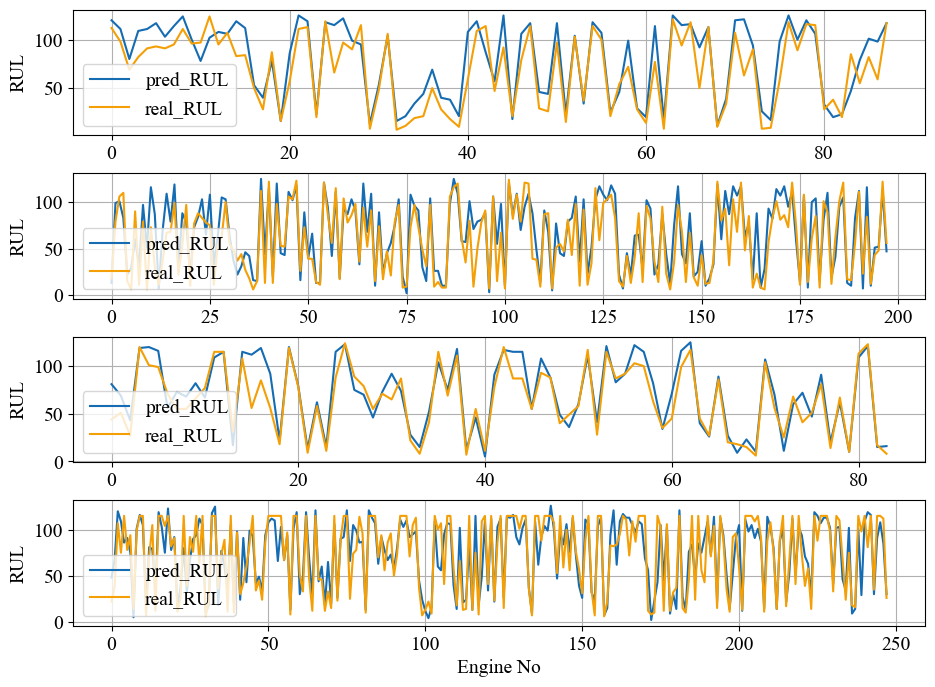

In [23]:
FD001_pred = np.loadtxt('./FD001_pred.txt',dtype=np.int,delimiter=None,unpack=False)
FD001_real = np.loadtxt('./FD001_real.txt',dtype=np.int,delimiter=None,unpack=False)
FD002_pred = np.loadtxt('../FD002/FD002_pred.txt',dtype=np.int,delimiter=None,unpack=False)
FD002_real = np.loadtxt('../FD002/FD002_real.txt',dtype=np.int,delimiter=None,unpack=False)
FD003_pred = np.loadtxt('../FD003/FD003_pred.txt',dtype=np.int,delimiter=None,unpack=False)
FD003_real = np.loadtxt('../FD003/FD003_real.txt',dtype=np.int,delimiter=None,unpack=False)
FD004_pred = np.loadtxt('../FD004/FD004_pred.txt',dtype=np.int,delimiter=None,unpack=False)
FD004_real = np.loadtxt('../FD004/FD004_real.txt',dtype=np.int,delimiter=None,unpack=False)

plt.figure(figsize=(11, 8))
plt.subplot(411)
plt.plot(FD001_pred, color='#156CB3', label='pred_RUL')
plt.plot(FD001_real, color='#F49F05', label='real_RUL')
plt.grid()
plt.legend(loc='lower left')
# plt.title('FD001')
plt.ylabel("RUL")

plt.subplot(412)
plt.plot(FD002_pred, color='#156CB3', label='pred_RUL')
plt.plot(FD002_real, color='#F49F05', label='real_RUL')
plt.grid()
plt.legend(loc='lower left')
# plt.title('FD002')
plt.ylabel("RUL")

plt.subplot(413)
plt.plot(FD003_pred, color='#156CB3', label='pred_RUL')
plt.plot(FD003_real, color='#F49F05', label='real_RUL')
plt.grid()
plt.legend(loc='lower left')
# plt.title('FD003')
plt.ylabel("RUL")

plt.subplot(414)
plt.plot(FD004_pred, color='#156CB3', label='pred_RUL')
plt.plot(FD004_real, color='#F49F05', label='real_RUL')
plt.grid()
plt.legend(loc='lower left')
# plt.title('FD004')
plt.xlabel("Engine No")
plt.ylabel("RUL")

plt.subplots_adjust(hspace=0.3)



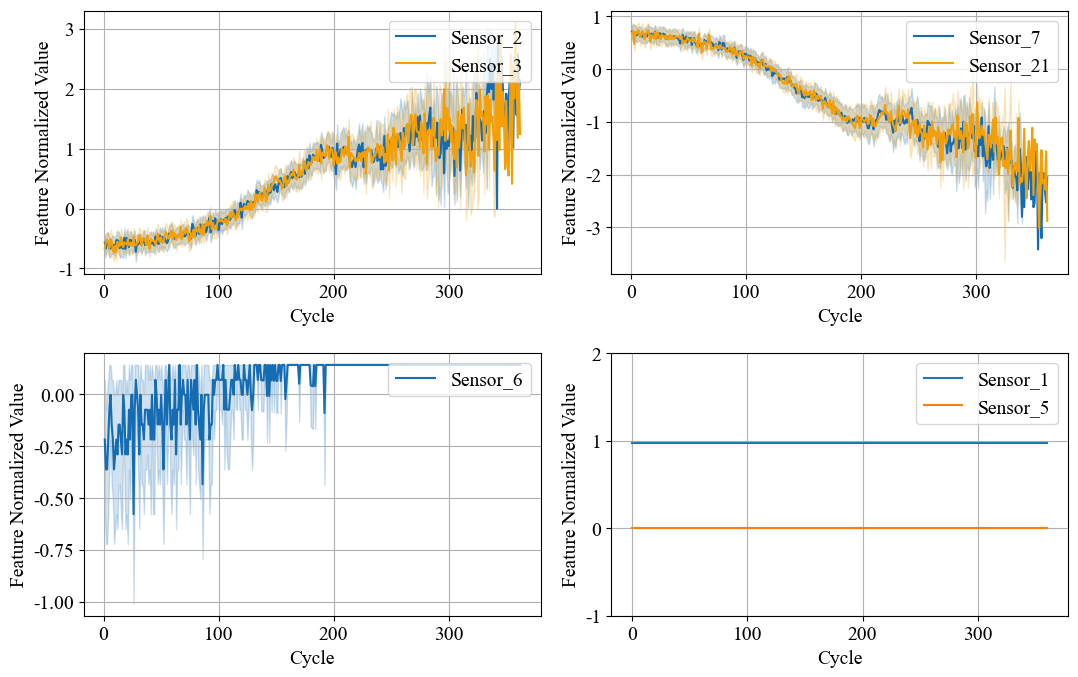

In [16]:
plt.figure(figsize=(11, 7))
plt.subplot(221)
sns.lineplot(x="cycle", y="s2", data=train_data, color='#156CB3', label='Sensor_2')
sns.lineplot(x="cycle", y="s3", data=train_data, color='#F49F05', label='Sensor_3')
plt.xlabel('Cycle')
plt.ylabel('Feature Normalized Value')
plt.legend(loc='upper right')
plt.grid()
plt.subplot(222)
sns.lineplot(x="cycle", y="s7", data=train_data, color= '#156CB3', label='Sensor_7')
sns.lineplot(x="cycle", y="s21", data=train_data, color='#F49F05', label='Sensor_21')
plt.xlabel('Cycle')
plt.ylabel('Feature Normalized Value')
plt.legend(loc='upper right')
plt.grid()
plt.subplot(223)
sns.lineplot(x="cycle", y="s6", data=train_data, color='#156CB3', label='Sensor_6')
plt.xlabel('Cycle')
plt.ylabel('Feature Normalized Value')
plt.legend(loc='upper right')
plt.grid()
plt.subplot(224)
# sns.lineplot(x="cycle", y="s1", data=train_data, color='#F49F05', label='Sensor_1')
# sns.lineplot(x="cycle", y="s5", data=train_data, color='#F49F05', label='Sensor_5')
plt.plot((data.loc[:360,'s1'] - np.max(data.loc[:360,'s5']))/np.min(data.loc[:360,'s1']), label='Sensor_1')
plt.plot((data.loc[:360,'s5'] - np.max(data.loc[:360,'s5']))/np.min(data.loc[:360,'s5']), label='Sensor_5')
plt.yticks([-1,0,1,2])
plt.xlabel('Cycle')
plt.ylabel('Feature Normalized Value')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
# plt.savefig("D:/workspace/paper/1/figs/features.png",dpi=600)

In [ ]:
fig = plt.figure(figsize=(8, 4))
x = [i for i in range(479-192)]
ax1 = fig.add_subplot(111)

rul = []
feature = train_data.loc[192:478, 's3'].values
for d in train_data.loc[192:478, 'RUL']:
    if d > 115:
        rul.append(115)
    else:
        rul.append(d)

_rul_, = ax1.plot(x,rul,color='#156CB3', label='RUL')
ax1.set_ylabel('Cycle Life')
ax1.set_xlabel('Cycle')
plt.grid()
ax2 = ax1.twinx()
_feature_, = ax2.plot(x, feature,color='#F49F05', label='Sensor_3')
ax2.set_ylabel('Feature value')

lns = [_rul_,_feature_]
labels = [l.get_label() for l in lns]
plt.legend(lns,labels)

plt.savefig("D:/workspace/paper/1/figs/RUL_feature.png", bbox_inches='tight',dpi=600)

In [ ]:
plt.figure(figsize=(9, 8))
x = [i for i in range(479-192)]
rul = []
s3 = train_data.loc[192:478, 's3'].values
s6 = train_data.loc[192:478, 's6'].values
for d in train_data.loc[192:478, 'RUL']:
    if d > 115:
        rul.append(115)
    else:
        rul.append(d)
rul = np.array(rul)
plt.subplot(211)
plt.plot((s6 - np.min(s6))/(np.max(s6) - np.min(s6)), color='#156CB3', label='Sensor_6')
# plt.plot((s3 - np.min(s3))/(np.max(s3) - np.min(s3)), color='#F49F05', label='Sensor_3')
plt.plot((rul - np.min(rul))/(np.max(rul) - np.min(rul)), color='#A61B23', label='RUL')
plt.grid()
plt.xlabel('Cycles')
plt.ylabel('Normalized Values')
plt.legend(loc='lower right')
plt.subplot(212)
# plt.plot((s6 - np.min(s6))/(np.max(s6) - np.min(s6)), color='#156CB3', label='Sensor_6')
plt.plot((s3 - np.min(s3))/(np.max(s3) - np.min(s3)), color='#F49F05', label='Sensor_3')
plt.plot((rul - np.min(rul))/(np.max(rul) - np.min(rul)), color='#A61B23', label='RUL')
plt.grid()
plt.xlabel('Cycles')
plt.ylabel('Normalized Values')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("D:/workspace/paper/1/figs/feature_contrast.png", bbox_inches='tight',dpi=600)

In [ ]:
plt.figure(figsize=(5, 3))
sns.lineplot(x="cycle", y="s1", data=train_data )
sns.lineplot(x="cycle", y="s2", data=train_data )
sns.lineplot(x="cycle", y="s3", data=train_data )
sns.lineplot(x="cycle", y="s6", data=train_data )
sns.lineplot(x="cycle", y="s7", data=train_data )
sns.lineplot(x="cycle", y="s21", data=train_data)
plt.grid()
plt.xlabel('Cycle')
plt.ylabel('Feature Normalized Value')
plt.tight_layout()
# plt.legend(ncol=4, labelspacing=-2, loc='lower left',frameon=False, bbox_to_anchor=(0,-0.33),borderaxespad = 0.)
plt.savefig("D:/workspace/paper/1/figs/normalized_features.png", bbox_inches='tight',dpi=600)

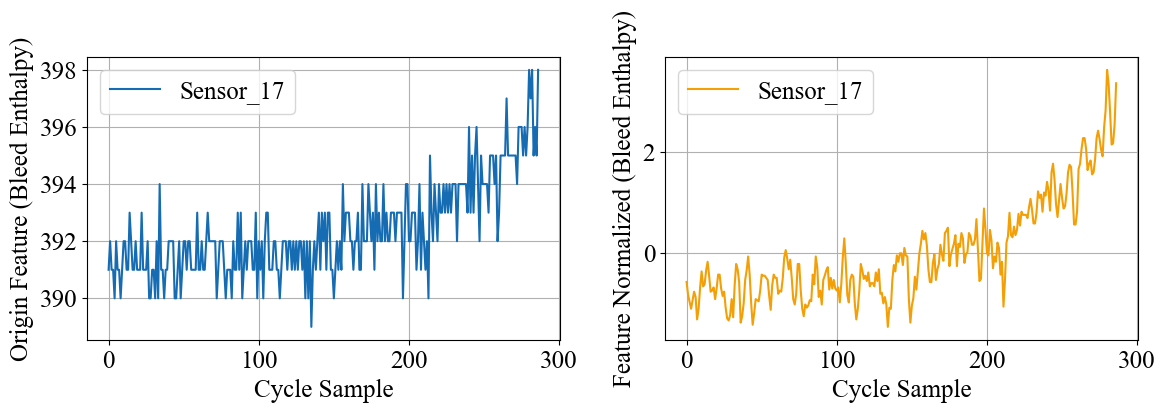

In [19]:

feature = data.loc[192:478, 's17'].values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(feature, color='#156CB3', label='Sensor_17')
plt.xlabel('Cycle Sample')
plt.ylabel('Origin Feature (Bleed Enthalpy)')
plt.grid()
plt.legend()

feature = savgol_filter(feature,6,2)

plt.subplot(122)
plt.plot((feature-np.mean(feature)) / np.std(feature), color='#F49F05', label='Sensor_17')
plt.xlabel('Cycle Sample')
plt.ylabel('Feature Normalized (Bleed Enthalpy)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("D:/workspace/paper/1/figs/denoise_features.png", bbox_inches='tight',dpi=600)

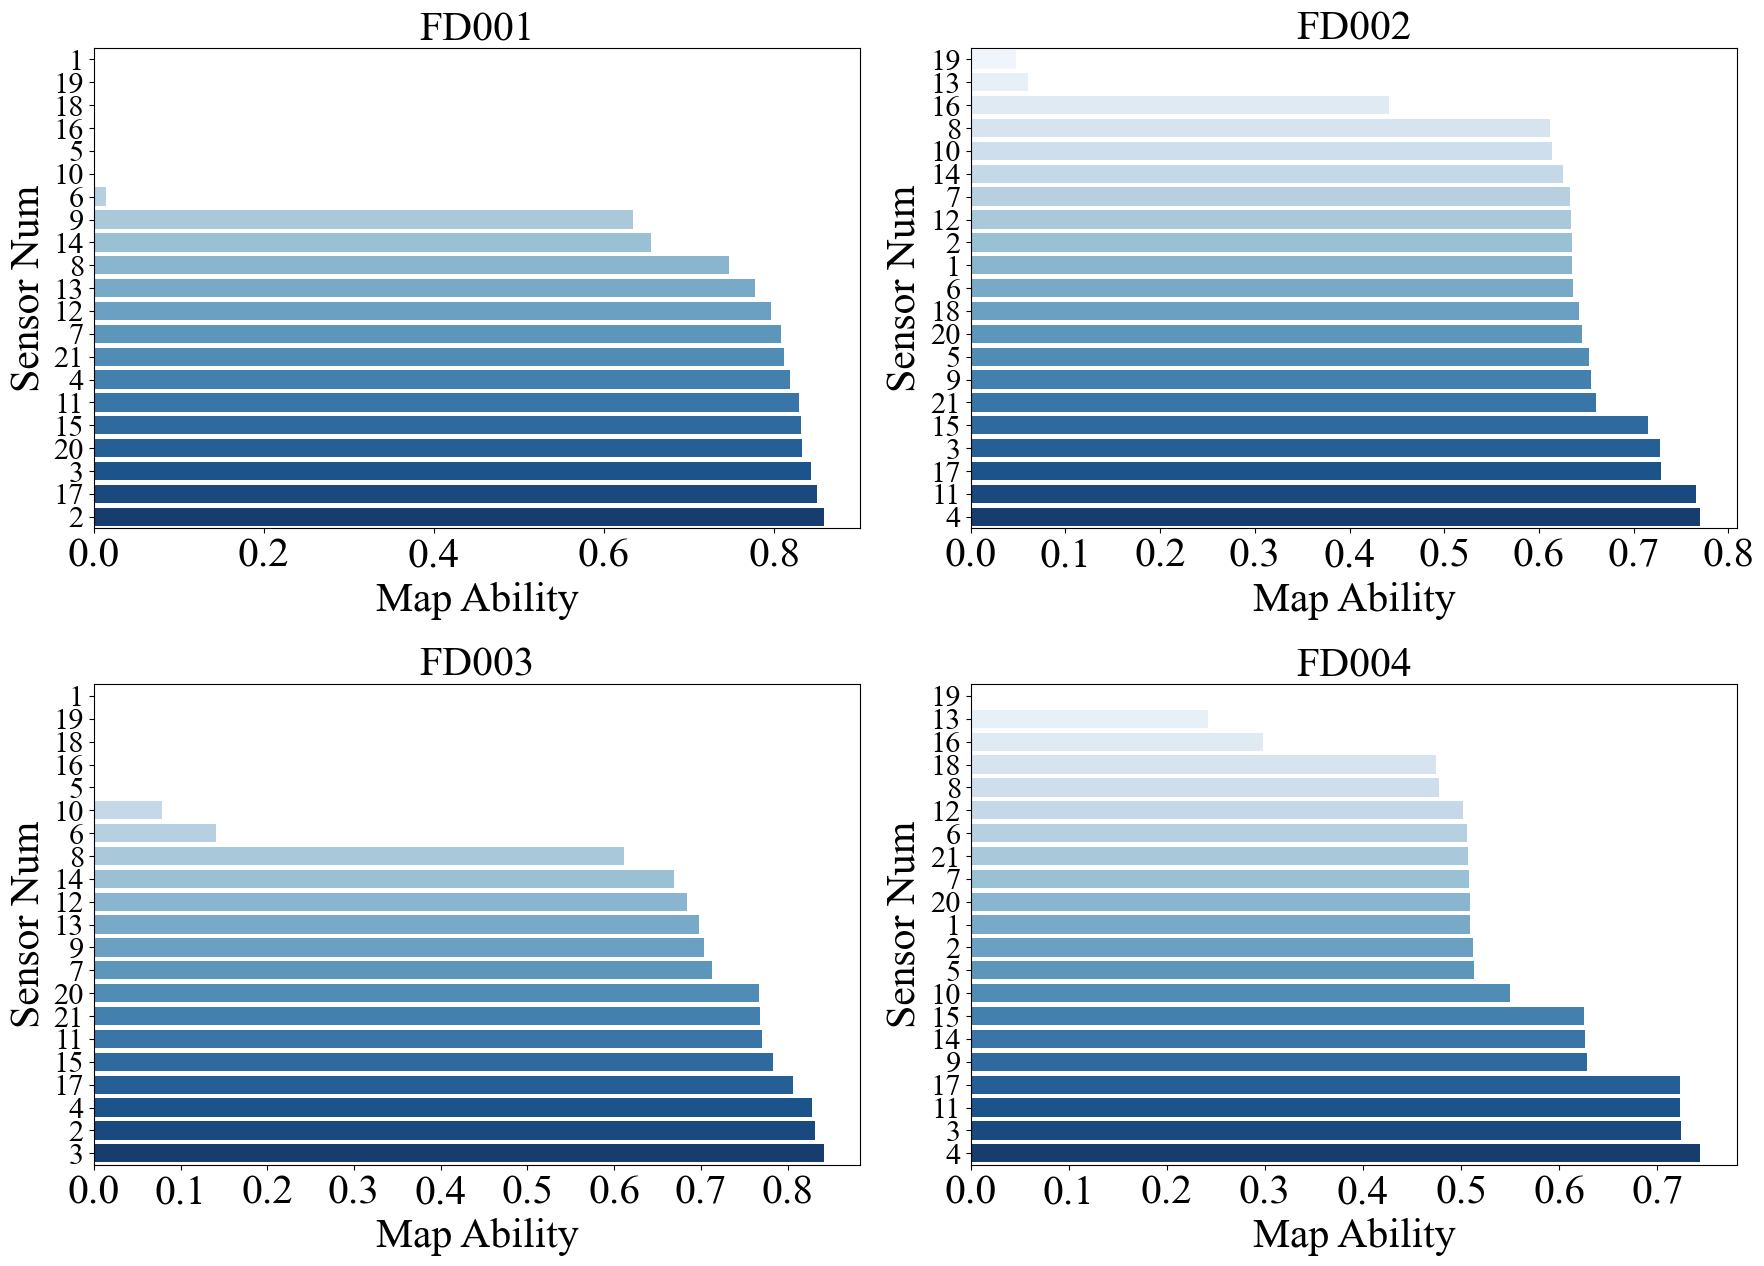

In [20]:
current_palette = sns.color_palette('blend:#7AB,#EDA', n_colors=24)
plt.figure(figsize=(18, 13))

plt.subplot(221)
weighted_value=[ -1.3525545291981995, 0.8580708041129999, 0.8432959040345853, 0.8185273692842254, -0.08518421240324271, 0.014344690169709321, 0.8080746736887614, 0.7464706886790279, 0.634078690879124, -1.3525545291981995, 0.8293482132538018, 0.7959397025237085, 0.7769987758394079, 0.6557361651410154, 0.8319090714471812, -0.08518421240324271, 0.8503126509071743, -1.3525545291981995, -1.3525545291981995, 0.8332705563081861, 0.8112508345938821]
weights = [w if w >=0 else 0 for w in weighted_value]
waters= ['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
df = pd.DataFrame({'features':waters, 'importance':weights})
df.sort_values(by=['importance'],ascending=True,inplace=True)
sns.barplot(x="importance", y="features", data=df, orient='h',palette='Blues')
plt.xlabel("Map Ability", fontsize="30")
plt.ylabel("Sensor Num", fontsize="30")
plt.xticks(fontsize="30")
plt.yticks(fontsize="22")
plt.title("FD001", fontsize="30")

plt.subplot(222)
weighted_value=[ 0.6349856534065781, 0.6345172254497131, 0.7280255036646421, 0.7704532243067866, 0.6532500146918113, 0.635776697712685, 0.6322822645235303, 0.6114007857498442, 0.6549378349486613, 0.6139399959958015, 0.7652670869094798, 0.6338647669024404, 0.06011263052365457, 0.6250947719475386, 0.7146342024839003, 0.4415509624016986, 0.7288263251986141, 0.6421262526277283, 0.047940830293252766, 0.6449865864287931, 0.660358380479112]
weights = [w if w >=0 else 0 for w in weighted_value]
waters= ['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
df = pd.DataFrame({'features':waters, 'importance':weights})
df.sort_values(by=['importance'],ascending=True,inplace=True)
sns.barplot(x="importance", y="features", data=df, orient='h',palette='Blues')
plt.xlabel("Map Ability", fontsize="30")
plt.ylabel("Sensor Num", fontsize="30")
plt.xticks(fontsize="30")
plt.yticks(fontsize="22")
plt.title("FD002", fontsize="30")

plt.subplot(223)
weighted_value=[-1.5574784656475686, 0.8316110515289997, 0.841343175823377, 0.8285534873681247, -0.09808395402285239, 0.1407054700381496, 0.7127104062989118, 0.6109340608867988, 0.7037998406043584, 0.07869900923286073, 0.770199743253822, 0.6844810775917795, 0.6976549117990988, 0.6692217970981309, 0.7829009830050208, -0.09808395402285239, 0.8066354612199966, -1.5574784656475686, -1.5574784656475686, 0.7671878545340377, 0.7679127656271648]
weights = [w if w >=0 else 0 for w in weighted_value]
waters= ['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
df = pd.DataFrame({'features':waters, 'importance':weights})
df.sort_values(by=['importance'],ascending=True,inplace=True)
sns.barplot(x="importance", y="features", data=df, orient='h',palette='Blues')
plt.xlabel("Map Ability", fontsize="30")
plt.ylabel("Sensor Num", fontsize="30")
plt.xticks(fontsize="30")
plt.yticks(fontsize="22")
plt.title("FD003", fontsize="30")

plt.subplot(224)
weighted_value=[ 0.5089387560755972, 0.5121675290589925, 0.7240903718579894, 0.7440636647722043, 0.5126518120078876, 0.506333457562931, 0.507563206383561, 0.4776631277837427, 0.6279954541821787, 0.5500065837118352, 0.7234265002200237, 0.5021685035072925, 0.24183469235576593, 0.6264476558593762, 0.6248106457731102, 0.2984575273162594, 0.7227375654379092, 0.47479686150199546, -0.016127577443375733, 0.5089173115135502, 0.5070780838586685]
weights = [w if w >=0 else 0 for w in weighted_value]
waters= ['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
df = pd.DataFrame({'features':waters, 'importance':weights})
df.sort_values(by=['importance'],ascending=True,inplace=True)
sns.barplot(x="importance", y="features", data=df, orient='h',palette='Blues')
plt.xlabel("Map Ability", fontsize="30")
plt.ylabel("Sensor Num", fontsize="30")
plt.xticks(fontsize="30")
plt.yticks(fontsize="22")
plt.title("FD004", fontsize="30")

plt.tight_layout()

plt.savefig("D:/workspace/paper/1/figs/features_select.png",dpi=800)

In [ ]:
df = pd.read_csv('./size_result.csv')

In [ ]:
rc = {'font.sans-serif': ['Times New Roman']}
sns.set(context='notebook', style='ticks',rc=rc)
sns.boxplot(x="engine_id", hue="model_size", y="rmse", data=df, palette="Blues")
plt.grid()
plt.savefig("D:/workspace/paper/1/figs/model_size.png", bbox_inches='tight',dpi=600)

In [11]:
df = pd.read_csv('./size_result_2.csv')

<Figure size 800x400 with 0 Axes>

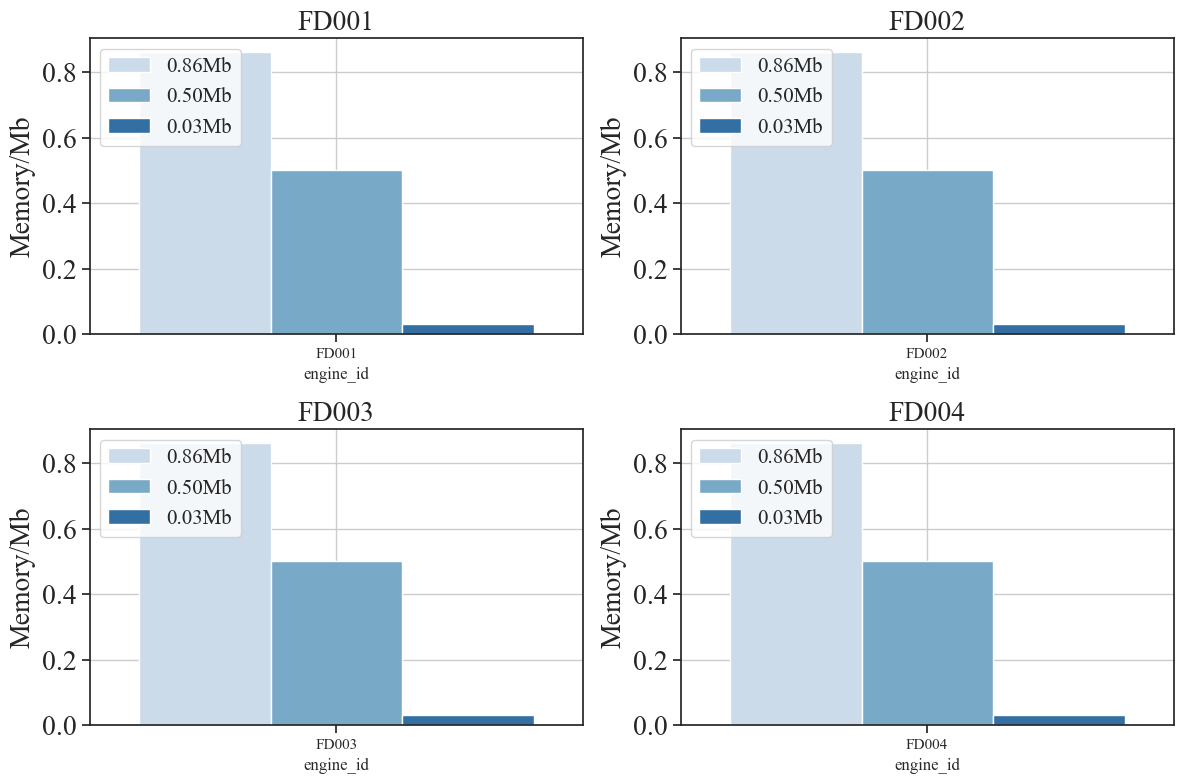

In [12]:
plt.figure(figsize=(8, 4))
rc = {'font.sans-serif': ['Times New Roman']}
sns.set(context='notebook', style='ticks',rc=rc)
plt.figure(figsize=(12, 8))

plt.subplot(221)
sns.barplot(x='engine_id',y='size',hue='model_size',data=df[df.engine_id == 'FD001'], palette="Blues")
plt.legend(loc='upper left',fontsize="15")
plt.title('FD001',fontsize="20")
plt.yticks(fontsize="20")
plt.ylabel('Memory/Mb',fontsize="20")
plt.grid()

plt.subplot(222)
sns.barplot(x='engine_id',y='size',hue='model_size',data=df[df.engine_id == 'FD002'], palette="Blues")
plt.legend(loc='upper left',fontsize="15")
plt.title('FD002',fontsize="20")
plt.yticks(fontsize="20")
plt.ylabel('Memory/Mb',fontsize="20")
plt.grid()

plt.subplot(223)
sns.barplot(x='engine_id',y='size',hue='model_size',data=df[df.engine_id == 'FD003'], palette="Blues")
plt.legend(loc='upper left',fontsize="15")
plt.title('FD003',fontsize="20")
plt.yticks(fontsize="20")
plt.ylabel('Memory/Mb',fontsize="20")
plt.grid()

plt.subplot(224)
sns.barplot(x='engine_id',y='size',hue='model_size',data=df[df.engine_id == 'FD004'], palette="Blues")
plt.legend(loc='upper left',fontsize="15")
plt.title('FD004',fontsize="20")
plt.yticks(fontsize="20")
plt.ylabel('Memory/Mb',fontsize="20")
plt.grid()

plt.tight_layout()

plt.savefig("D:/workspace/paper/1/figs/model_size_test.png", bbox_inches='tight',dpi=800)

In [ ]:
rc = {'font.sans-serif': ['Times New Roman']}
sns.set(context='notebook', style='ticks',rc=rc)
sns.set_theme(style="whitegrid")
sns.catplot(
    data=df, x="model_size", y="rmse", hue="index", col="engine_id",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)

In [3]:
df = pd.read_csv('./opt_result.csv')

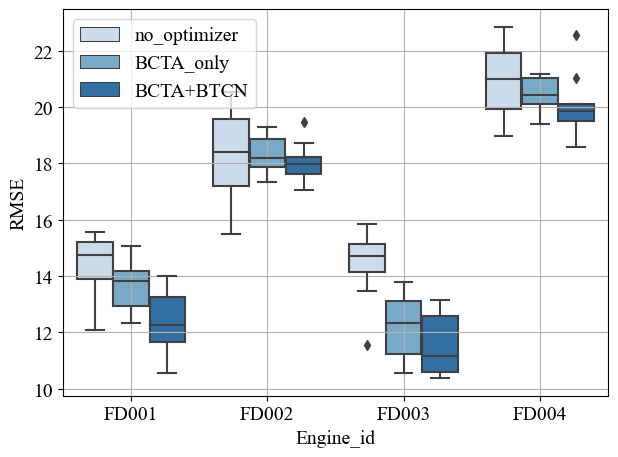

In [5]:
ax = sns.boxplot(x="Engine_id", hue="opt_method", y="RMSE", data=df, palette="Blues")
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig("D:/workspace/paper/1/figs/model_optimized.png", bbox_inches='tight',dpi=600)

In [ ]:
df = pd.read_csv('./attention.csv')

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.boxplot(data=df, palette="Blues")
plt.legend(loc='upper left')
plt.grid()
# plt.savefig("D:/workspace/paper/1/figs/model_optimized.png", bbox_inches='tight',dpi=600)

In [ ]:
plt.figure(figsize=(12, 4))
data = savgol_filter(test_data.loc[3000:5000,'s3'],15,5)
y = test_data.loc[3000:5000,'RUL']
plt.plot(data/np.max(data))
# plt.plot(y/np.max(y))

In [ ]:
df1 = pd.read_csv('./attention.csv')
df2 = pd.read_csv('../FD002/attention.csv')
plt.figure(figsize=(10, 10))
plt.subplot(211)
ax1 = sns.boxplot(data=df1, palette="Blues")
plt.grid()
plt.xlabel('Sensor Num')
plt.ylabel('Feature Attention')
plt.title('FD001')
plt.subplot(212)
ax2 = sns.boxplot(data=df2, palette="Blues")
plt.legend(loc='upper left')
plt.xlabel('Sensor Num')
plt.ylabel('Feature Attention')
plt.title('FD002')
plt.grid()
plt.tight_layout()
plt.savefig("D:/workspace/paper/1/figs/model_attention.png", bbox_inches='tight',dpi=800)

In [ ]:
plt.plot(train_data.loc[:300,'s20'])